In [1]:
import tensorflow as tf
#It will generate plots of attentations in order to see which part of the image 
#Model focusing on during captioning
import matplotlib.pyplot as plt
import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image
import tqdm
from tqdm import tqdm 

In [2]:
#Download Caption annotation file
annotation_folder='/annotations/'
if not os.path.exists(os.path.abspath('.')+annotation_folder):
  annotation_zip=tf.keras.utils.get_file('captions.zip',cache_subdir=os.path.abspath('.'),
                                          origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract=True)
  annotation_file=os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)
#Download image file
image_folder='/train2014/'  
if not os.path.exists(os.path.abspath('.')+image_folder):
  image_zip=tf.keras.utils.get_file('train2014.zip',cache_subdir=os.path.abspath('.'),
                                          origin='http://images.cocodataset.org/zips/train2014.zip',
                                          extract=True)
  PATH=os.path.dirname(image_zip)+image_folder
  os.remove(image_zip)
else:
  PATH=os.path.abspath('.')+image_folder
    

13510573713/13510573713 [==============================] - 782s 0us/step


#Limit The Size Of Trainning Set

In [3]:
with open(annotation_file,'r') as f:
   annotations=json.load(f)

In [4]:
#Group all the Caption Togather Having Same Image ID
image_path_to_caption=collections.defaultdict(list)
for val in annotations['annotations']:
  caption=f"<start> {val['caption']} <end>"
  image_path=PATH +'COCO_train2014_'+'%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [33]:
image_paths=list(image_path_to_caption.keys())
random.shuffle(image_paths)

#Select the first 6000 image_paths from the suffled set
#Approximatly each image id has 5 captions associated with it,so that will
#Lead to 30,000 examples
train_image_paths=image_paths[:6000]
print(len(train_image_paths))

6000


In [34]:
train_captions=[]
img_name_vactor=[]
for image_path in train_image_paths:
    caption_list=image_path_to_caption[image_path]
    train_captions.extend(caption_list)
    img_name_vactor.extend([image_path] * len(caption_list))

<start> A person using a laptop wearing a patriotic hat <end>


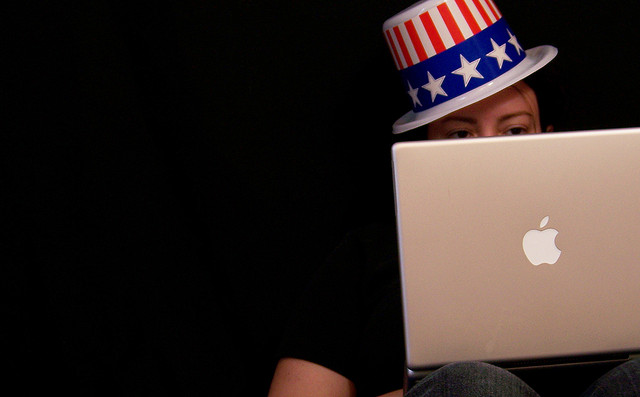

In [35]:
print(train_captions[6])
Image.open(img_name_vactor[6])

# Processe The Images Using InceptionV3

 '''First we have to convert each image to inceptionv3 format'''


*   Resizing the Image to 290px by 290px
*   Processes the image into process_input Method to normalize the image so it contains pixels in range -1 to 1 which matches the format of the images used to train InceptionV3





In [36]:
def load_image(image_path):
   img=tf.io.read_file(image_path)
   img=tf.io.decode_jpeg(img,channels=3)
   img=tf.image.resize(img,(299,299))
   img=tf.keras.applications.inception_v3.preprocess_input(img)
   return img,image_path

#Initialize the InceptionV3 and load the Pretrained Imagenet Weights

'''Now we will create a  tf.keras model where the output layer is thre last convolution layer in the InceptionV3 architecture.The shape of the output layer is 8X8X2048.We use the last convolution layer.Because we are using attentation in this example.We don't perform initrialization during trainning phase because it becomes bottleneck'''


* We forward each image into the network and store the resulting vector into a dictionary.(image_name--->feature_vector)
* After all the i8mages arte passed through the network we will save the model in the disk



In [37]:
image_model=tf.keras.applications.InceptionV3(include_top=False,
                                              weights="imagenet")
new_input=image_model.input
hidden_layer=image_model.layers[-1].output

image_fetaures_extract_model=tf.keras.Model(new_input,hidden_layer)

#Caching the features extracted from inceptionv3

In [38]:
#Get the unique images
encode_train=sorted(set(img_name_vactor))
image_dataset=tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset=image_dataset.map(load_image,num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img,path in tqdm(image_dataset):
  batch_features=image_fetaures_extract_model(img)
  batch_features=tf.reshape(batch_features,(batch_features.shape[0],-1,batch_features.shape[3]))
  for bf,p in zip(batch_features,path):
     path_of_feature = p.numpy().decode("utf-8")
     np.save(path_of_feature,bf.numpy())



100%|██████████| 375/375 [02:22<00:00,  2.64it/s]


#Preprocessing and Tokenize the caption


* First we will tokenize the caption(for example,by splitting on spaces).This gives us the vocabulary of all of the unique words in the data(for example 'surtfing','football')

* Next we will limit the vocabulary size to the top 5,000 words(to save the memory).we will replace aii t6he other words with the token 'UNK'(unknown)
*  Then we create word_to_index and index_to_word mapping
*  Finally we will pad all the sequences to the same length as the lomgest one



In [39]:
#Find the maximum length of any captionh in the dataset
def cal_max_len(tensor):
   return max(len(t) for t in tensor)

In [40]:
#Choose the top 5000 words from the Vocabulary
top_k=5000
tokenizer=tf.keras.preprocessing.text.Tokenizer(num_words=top_k,oov_token="<unk>",filters='!"#$&%()*?=;:^{}~`/|')
tokenizer.fit_on_texts(train_captions)

In [41]:
tokenizer.word_index['<pad>']=0
tokenizer.index_word[0]='<pad>'

In [42]:
#Create the Tokenize Vectors
train_seqs=tokenizer.texts_to_sequences(train_captions)

In [43]:
#Pad each vactor to the max length of the caption
#If we donot provide the max l;ength value4 then the mjax length calculate it automatically
cap_vector=tf.keras.preprocessing.sequence.pad_sequences(train_seqs,padding='post')

In [44]:
#Calculate the max length which used to store the attentation weight
max_length=cal_max_len(train_seqs) 

#Split the data into Train and Test

In [45]:
img_to_cap_vactor=collections.defaultdict(list)
for img,cap in zip(img_name_vactor,cap_vector):
   img_to_cap_vactor[img].append(cap)
#Create trainning and validation set usingan 80-20 set randomly
img_keys=list(img_to_cap_vactor.keys())
random.shuffle(img_keys)   

slice_index=int(len(img_keys)*0.8)
img_name_train_keys,img_name_val_keys=img_keys[:slice_index],img_keys[slice_index:]

img_name_train=[]
cap_train=[]
for imgt in img_name_train_keys:
    capt_len=len(img_to_cap_vactor[imgt])
    img_name_train.extend([imgt]*capt_len)
    cap_train.extend(img_to_cap_vactor[imgt])

img_name_val=[]
cap_val=[]
for imgv in img_name_val_keys:
    capv_len=len(img_to_cap_vactor[imgv])
    img_name_val.extend([imgv]*capt_len)
    cap_val.extend(img_to_cap_vactor[imgv])

In [46]:
len(img_name_train),len(cap_train),len(img_name_val),len(cap_val)

(24016, 24016, 6000, 6003)

#Create a tf datasaet For Trainning

In [47]:
BATCH_SIZE=64
BUFFER_SIZE=1000
embedding_dim=256
units=512
vocab_size=top_k+1
num_steps=len(img_name_train)//BATCH_SIZE
#Shape of the Vactor extracted from inceptionV3 is (64,2048)
#These two variable represents vactror space
features_shape=2048
attention_features_shape=64

In [48]:
#Load the numpy files 
def map_func(img_name,cap):
  img_tensor=np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor,cap

In [49]:
dataset=tf.data.Dataset.from_tensor_slices((img_name_train,cap_train))

#Use map to load numpy files in parallel
dataset=dataset.map(lambda item1,item2:tf.numpy_function(map_func,[item1,item2],[tf.float32,tf.int32]),num_parallel_calls=tf.data.AUTOTUNE)
dataset=dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
#Shbuffle and batch
dataset=dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset=dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

#Model


*   Here we extract the features from the lower convolution layer of inceptionV3 giving us a vactor of shape(8,8,2048)
*   we squash it into a shape of (64,2048)
*   The vactor then pass through the CNN Encoder(whichb consists of sinle fully connected layer)
*   The RNN(here GRU) attend over the image to predict the next word




In [50]:
class BahdanauAttention(tf.keras.Model):
      def __init__(self,units):
        super(BahdanauAttention,self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
      def call(self,features,hidden):
        #features(CNN_ecoder output) shape == (batch_size,64,embedding_dim)
        #hidden shape == (batch_size,1,hidden_size)
        hidden_with_time_axis=tf.expand_dims(hidden,1)
        #attentation_hidden_layer=(batch_size,64,units)
        attentation_hidden_layer=(tf.nn.tanh(self.W1(features)+self.W2(hidden_with_time_axis)))
        #Score shape == (batch_size,64,1)
        #This gives us a unnormalized score for each features
        score=self.V(attentation_hidden_layer)
        #Attention weights shape == (batch_size,64,1)
        attention_weights=tf.nn.softmax(score,axis=1)
        #context vactor shape after sum == (batch_size,hidden_size)
        context_vactor=attention_weights * features
        context_vactor=tf.reduce_sum(context_vactor,axis=1)

        return context_vactor,attention_weights

In [51]:
class CNN_Encoder(tf.keras.Model):
     #Since we alredy extracted the features and dumped it 
     #This Encoder passes the features through a fully connected layer
     def __init__(self,embedding_dim):
        super(CNN_Encoder,self).__init__()
        #shape after fc == (batch_size,64,embedding_dim)
     def call(self,x):
         x=self.fc(x)
         x=tf.nn.relu(x)
         return x
   

In [52]:
class RNN_Decoder(tf.keras.Model):
     def __init__(self,embedding_dim,units,vocab_size):
        super(RNN_Decoder,self).__init__()
        self.units=units
        self.embedding=tf.keras.layers.Embedding(vocab_size,embedding_dim)
        self.gru=tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.fc1=tf.keras.layers.Dense(self.units)
        self.fc2=tf.keras.layers.Dense(self.units)
        self.attention=BahdanauAttention(self.units)
     def call(self,x,features,hidden):
        #defining attention as a separate model
        context_vector,attention_weights=self.attention(features,hidden)
        #x shape after passing through embaddingds
        x=self.embedding(x)
        #x shape after concatinated vactor to GRU
        output,state=self.gru(x)
        #shape ==(batch_size,max_len,hidden_size)
        x=self.fc1(output)
        #x shape ==(batch_size*max_length,hidden_size)
        x=tf.reshape(x,(-1,x.shape[2]))
        return x,state,attention_weights
     def reset_state(self,batch_size):
        return tf.zeros((batch_size,self.units))





In [53]:
encoder=CNN_Encoder(embedding_dim)
decoder=RNN_Decoder(embedding_dim,units,vocab_size)

In [54]:
optimizer=tf.keras.optimizers.Adam()
loss_object=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction='none')
def loss_function(real,predict):
   mask=tf.math.logical_not(tf.math.equal(real,0))
   loss_=loss_object(real,predict)
   mask=tf.cast(mask,dtype=loss_.dtype)
   loss_==mask
   return tf.reduce_mean(loss_)

#Checkpoints

In [55]:
checkpoint_path="/checkpoints/train"
ckpt=tf.train.Checkpoint(encoder=encoder,decoder=decoder,optimizer=optimizer)
ckpt_manager=tf.train.CheckpointManager(ckpt,checkpoint_path,max_to_keep=5)

In [56]:
start_epoch=0
if ckpt_manager.latest_checkpoint:
   start_epoch=int(ckpt_manager.latest_checkpoint.split('-')[-1])
   #restoring the latest checkpoints in checkpoint_path
   ckpt.restore(ckpt_manager.latest_checkpoint) 

#Trainning 

In [57]:
#Adding this in a separate cell because if we run the cell trainning cell many time then the loss_plot array will reset
loss_plot=[]

In [58]:
@tf.function
def train_step(img_tensor,target):
  loss=0
  #initializing the hidden state for each batch
  #because the caption are not related from image to image
  hidden=decoder.reset_state(batch_size=target.shape[0])
  dec_input=tf.expand_dims([tokenizer.word_index['<start>']]*target.shape[0],1)
  
  with tf.GradientTape() as tape:
     features=encoder(img_tensor)

     for i in range(1,target[1]):
       #passing the features through the decoder
       predictions,hidden,_=decoder(dec_input,features,hidden)

       loss += loss_function(target[:,i],predictions)
       #using teacher forcing
       dec_input=tf.erxpand_dims(target[:,i],1)
  total_loss=(loss/int(target.shape[1]))
  trainable_variables=encoder.trainable_variables+decoder.trainable_variables
  gradients=tape.gradient(loss,trainable_variables)
  optimizer.apply_gradients(zip(gradients,trainable_variables))
  return loss,total_loss

In [ ]:
EPOCHS=20
for epoch in range(start_epoch,EPOCHS):
   start=time.time()
   total_loss=0
   for (batch,(img_tensor,target)) in enumerate(dataset):
        batch_loss,t_loss=train_step(img_tensor,target)
        total_loss += t_loss
        if batch%100==0:
           average_batch_loss=batch_loss.numpy()/int(target.shape[1])
           print(f'Epoch{epoch+1} Batch {batch} loss {average_batch_loss:.4f}')
        #storing the epoch value to the plot later
        loss_plot.append(total_loss/num_steps)

        if epoch % 5==0:
           ckpt_manager.save()
        print(f'Epoch{epoch+1} Batch {batch} loss {total_loss/num_steps:.6f}')
        print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [1]:
def evaluate(image):
    attention_plot=np.zeros((max_length,attention_features_shape))
    hidden=decoder.reset_state(batch_size=1)
    temp_input=tf.expand_dims(load_image[image][0],0)
    img_tensor_val=image_features_extract_model(temp_input)
    img_tensor_val=tf.reshape(img_tensor_val,(img_tensor_val.shape[0],-1,img_tensor_val.shape[3]))

    features=encoder(img_tensor_val)
    dec_input=tf.expand_dims([tokenizer.word_index['<start>']],0)
    result=[]
    
    for i in range(max_length):
        predictions,hidden,attentation_weights=decoder(dec_input,features,hidden)
        attention_plot[i]=tf.reshape(attentation_weights,(-1,)).numpy()
        prediction_id=tf.random.catagorical(predictions,1)[0][0].numpy()
        result.append(tokenizer.index_word[prediction_id])
        if tokenizer.index_word[prediction_id]=='<end>'
            return result,attention_plot
        dec_input = tf.expand_dims([prediction_id],0)
     attention_plot=attention_plot[:len(result),:]
     return result,attention_plot

In [ ]:
def plot_attention(image,result,attention_plot):
    temp_image=np.array(Image.open(image))

    fig=plt.figure(figsize=(10,10))

    len_result=len(result)
    for i in range(len_result):
        temp_att=np.resize(attention_plot[i],(8,8))
        grid_size=max(np.cell(len_result/2),2)
        ax=fig.add_subplot(grid_size,grid_size,i+1)
        ax.set_title(result[i])
        img=ax.imshow(temp_image)
        ax.imshow(temp_att,cmap='gray',alpha=0.6,extent=img.get_extend())
     plt.tight_layout()
     plt.show()    

In [ ]:
#caption on the validationset
rid=np.random.randint(0,len(img_name_val))
image=img_name_val[rid]
real_caption=" ".join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result,attention_plot=evaluate(image)

print('Real_Caption:',real_caption)
print("Prediction Caption:"," ".join(result))
plot_attention(image,result,attention_plot)

In [ ]:
image_url=
image_extension=image_url[-4:]
image_path=tf.keras.utils.get_file('image'+image_extension,origin=image_url)

result,attention_plot=evaluate(image_path)
print('Prediction Caption:',.join(result))
plot_attention(image_path,result,attention_plot)
Image.open(image_path)